# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import matplotlib.pyplot as plt
import os
import glob
import sys
import tensorflow as tf

from functools import partial
from itertools import product, islice
import itertools

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models
from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools


### Utilities

In [2]:
# https://stackoverflow.com/questions/43137288/how-to-determine-needed-memory-of-keras-model

def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes



## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [4]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [5]:
def encoder_block(input_layer, filters, strides):
    
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)

    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [6]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    output_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([output_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters, strides=1)
    output_layer = separable_conv2d_batchnorm(output_layer, filters, strides=1)

    return output_layer

### Downsampling Block
The decoder block is composed either with a maxpooling or a pooling layer with stride 2.

In [7]:
def downsampling_block(parent_layer, has_max_pool=True):
    if has_max_pool:
        pool_layer = layers.MaxPool2D(pool_size=(2,2), strides=2, padding="SAME")(parent_layer)
    else:
        filters = parent_layer.get_shape().as_list()[-1]
        pool_layer = encoder_block(parent_layer, filters, 2)
    return pool_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [8]:
def fcn_model(inputs, num_classes, has_max_pool, rate=None):
    if rate is None:
        rate = 0.2
 ##### Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    
    # block 1
    x0 = encoder_block(inputs, 16, 2)
    x1 = encoder_block(x0, 32, 1)
    pool1 = downsampling_block(x1, has_max_pool)
    x2 = layers.SpatialDropout2D(rate=rate)(pool1)
    
    # block 2
    x3 = encoder_block(x2, 64, 1)
    pool2 = downsampling_block(x3, has_max_pool)
    x4 = layers.SpatialDropout2D(rate=rate)(pool2)
    
    ##### 1x1 Convolution layer using conv2d_batchnorm().
    # block 3
    x5 = conv2d_batchnorm(x4, 128, kernel_size=(1,1), strides=1)
    
    ##### Decoder Blocks as the number of Encoder Blocks
    # block 4
    x6 = decoder_block(x5, x3, 64)
    x7 = layers.SpatialDropout2D(rate=rate)(x6)
    
    # block 5
    x8 = decoder_block(x7, x1, 32)
    x9 = layers.SpatialDropout2D(rate=rate)(x8)
    x10 = bilinear_upsample(x9)
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x10)

In [110]:
def fcn_model2(inputs, num_classes, has_max_pool, rate=None):
    if rate is None:
        rate = 0.2
 ##### Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    
    # block 1
    #x0 = encoder_block(inputs, 16, 2)
    x1 = encoder_block(inputs, 32, 1)
    pool1 = downsampling_block(x1, has_max_pool)
    x2 = layers.SpatialDropout2D(rate=rate)(pool1)
    
    # block 2
    x3 = encoder_block(x2, 64, 1)
    pool2 = downsampling_block(x3, has_max_pool)
    x4 = layers.SpatialDropout2D(rate=rate)(pool2)
    
    # block 2
    x5 = encoder_block(x4, 128, 1)
    pool3 = downsampling_block(x5, has_max_pool)
    x6 = layers.SpatialDropout2D(rate=rate)(pool3)
    
    ##### 1x1 Convolution layer using conv2d_batchnorm().
    # block 3
    x = conv2d_batchnorm(x6, 256, kernel_size=(1,1), strides=1)
    
    ##### Decoder Blocks as the number of Encoder Blocks
    # block 4
    x7 = decoder_block(x, x5, 128)
    x8 = layers.SpatialDropout2D(rate=rate)(x7)
      
    # block 4
    x9 = decoder_block(x8, x3, 64)
    x10 = layers.SpatialDropout2D(rate=rate)(x9)
    
    # block 5
    x11 = decoder_block(x10, x1, 32)
    x12 = layers.SpatialDropout2D(rate=rate)(x11)
    #x13 = bilinear_upsample(x12)
    #x13 = decoder_block(x12, inputs, 16)
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x12)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [143]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model2(inputs, num_classes, rate=0.1, has_max_pool=True)

In [144]:
train_size = len(os.listdir("../data/train_combined/images/"))
val_size = len(os.listdir("../data/validation/images/"))

In [145]:
learning_rate = 0.001
batch_size = 8
num_epochs = 30
steps_per_epoch = int(train_size/batch_size)
validation_steps = int(val_size/batch_size)
workers = 2

##### Class weighting

In [15]:
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train_combined'),
                                               image_shape=image_shape,
                                               shift_aug=True)


def compute_class_weights(train_iter, n=100, skip=2):
    counts = np.zeros(3)
    total = 0
    pix_by_img = image_hw**2
    for _, masks in islice(train_iter, 0, n, skip):
        total += masks.shape[0] * pix_by_img
        counts += (masks[:,:,:,:] != 0).sum(axis=(0,1,2))
    return (counts / total) + 10e-10

def normalize(arr):
    return arr / arr.sum()

def compute_inverse_class_weight(class_weights):
    inverse = 1/class_weights
    inverse /= inverse.sum()
    return inverse



def w_categorical_crossentropy(weights):
    def loss_func(target, output, from_logits=False):
      # Note: nn.softmax_cross_entropy_with_logits
      # expects logits, Keras expects probabilities.
      if not from_logits:
        # scale preds so that the class probas of each sample sum to 1
        output /= tf.reduce_sum(
            output, axis=len(output.get_shape()) - 1, keep_dims=True)
        # manual computation of crossentropy
        epsilon_ = tf.convert_to_tensor(10e-8, output.dtype.base_dtype)
        output = tf.clip_by_value(output, epsilon_, 1. - epsilon_)
        return -tf.reduce_sum(
            weights * target * tf.log(output),
            axis=len(output.get_shape()) - 1)
      else:
        return tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=output)
    return loss_func


class WeightedLossCallback(keras.callbacks.Callback):
    """update the weigths linearly until the target_epoch is reached.
    """
    def __init__(self,target_epoch, base_weights, final_weights=None):
        self.target_epoch = target_epoch
        self.base_weights = base_weights
        if final_weights is None:
            self.final_weights = np.ones_like(self.base_weights)
        else:
            self.final_weights = final_weights
        
        self.weights = base_weights
        self.w_delta = self.final_weights - self.weights
        
        super(WeightedLossCallback, self).__init__()
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch >= self.target_epoch:
            self.weights = self.final_weights
        else:
            t_delta = epoch / self.target_epoch
            self.weights = self.base_weights + self.w_delta * t_delta
        
    def loss(self, target, output, from_logits=False):
          # Note: nn.softmax_cross_entropy_with_logits
          # expects logits, Keras expects probabilities.
          if not from_logits:
            # scale preds so that the class probas of each sample sum to 1
            output /= tf.reduce_sum(
                output, axis=len(output.get_shape()) - 1, keep_dims=True)
            # manual computation of crossentropy
            epsilon_ = tf.convert_to_tensor(10e-8, output.dtype.base_dtype)
            output = tf.clip_by_value(output, epsilon_, 1. - epsilon_)
            return -tf.reduce_sum(
                self.weights * target * tf.log(output),
                axis=len(output.get_shape()) - 1)
          else:
            return tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=output)


In [294]:
class_weights = compute_class_weights(train_iter)
inverse_class_weights = compute_inverse_class_weight(class_weights)
sample_weight_matrix = get_sample_weight_matrix(inverse_class_weights, image_shape, batch_size)

In [295]:
print("class weights sampled from dataset: {}".format(inverse_class_weights))

class weights sampled from dataset: [ 0.00241022  0.14757306  0.85001672]


First training with the sample weights gave us loss: 0.0015 - categorical_crossentropy: 0.2611 - val_loss: 0.0018 - val_categorical_crossentropy: 0.2748 after 10 iteration. 

we are going to increase the weights linearly using the callback functionality in Keras and our WeightedLossCallback.

In [146]:
loss = w_categorical_crossentropy(np.array([1.0, 1.05, 1.1]))

In [147]:

# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

#'categorical_crossentropy'
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss=loss, metrics=['categorical_crossentropy'])
model.summary()
print("Model Memory Size: {} Gb".format(get_model_memory_usage(batch_size, model)))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 160, 160, 3)   0                                            
____________________________________________________________________________________________________
separable_conv2d_keras_72 (Separ (None, 160, 160, 32)  155         input_7[0][0]                    
____________________________________________________________________________________________________
batch_normalization_78 (BatchNor (None, 160, 160, 32)  128         separable_conv2d_keras_72[0][0]  
____________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)   (None, 80, 80, 32)    0           batch_normalization_78[0][0]     
___________________________________________________________________________________________

Epoch 1/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.1637 - categorical_crossentropy: 0.1618   ETA: 143s - loss: 0.3966 - categorical_cros - ETA: 129s - loss: 0.3410 - categorical_ - ETA: 121s - - ETA: 116s - los - ETA: 112s - loss: 0.2929 - ca - ETA: 10 - ETA: 104s - loss: 0.2744 - categorical_cr - ETA: 102s - loss: 0.2709 - categorical_crossentropy: 0.26 - ETA: 102s - loss: 0.2705 -   - ETA: 49s - loss: 0.1987 - categor - ETA: 44s - los - ETA: 36s - loss: 0.1872 - catego - ETA: 31s - loss: 0.1833 - categorica

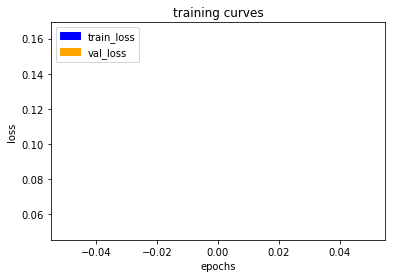

1032/1032 [==============================] - 217s - loss: 0.1636 - categorical_crossentropy: 0.1616 - val_loss: 0.0509 - val_categorical_crossentropy: 0.0493
Epoch 2/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0408 - categorical_crossentropy: 0.0394   ETA: 123s - loss: 0.0434 - categorical_crossentropy: 0.04 - ETA: 123s - loss: 0.0433 - categorica - E - ETA: 109s - loss: 0.0423 - catego - ETA: 100s - loss: 0.04 - ETA: 94s - loss: 0.0432 - ETA: 87s - loss: 0.0428 - categorical_cross - ETA: 84s - loss: 0.0426 - categorical_crossentropy: 0.04 - ETA: 84s - - ETA: 50s - loss - ETA: 42s - loss: 0.0415 - categorical_crossen - ET - ETA: 28s - loss: 0.0410 - categorical_ - ETA: 24s - loss: 0.0411 - ETA: 7s - loss: 0.0407 - categorica - ETA: 5s - loss: 0.0406 - categorical_ - ETA: 3s - loss: 0.0405 

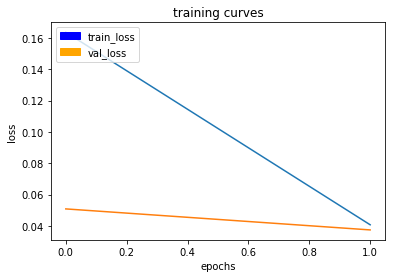

1032/1032 [==============================] - 217s - loss: 0.0408 - categorical_crossentropy: 0.0394 - val_loss: 0.0375 - val_categorical_crossentropy: 0.0361
Epoch 3/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0338 - categorical_crossentropy: 0.0326 - ETA: 98s - loss: 0.0345 - categorical_crossentropy: - ETA: 97s - loss: 0.0344 - categorical_crossentropy: 0.033 - ETA: 97s - l - ETA: 88s -   - ETA: 42s -  - ETA: 33s - loss: 0.0343 - categorical_crossentropy: 0.033 - ETA: 33s - loss: 0.0343 - categoric - ETA: 28s - loss: 0.0342 - cate - ETA: 23s - los

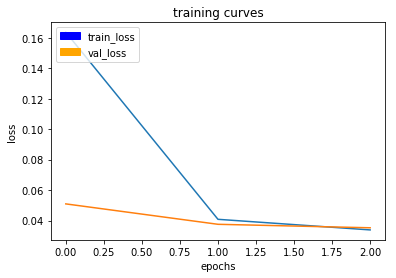

1032/1032 [==============================] - 217s - loss: 0.0338 - categorical_crossentropy: 0.0326 - val_loss: 0.0352 - val_categorical_crossentropy: 0.0342
Epoch 4/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0307 - categorical_crossentropy: 0.0296   ETA: 115s - loss:  - ETA: 62s - loss: 0.0315 - categorical_cross - ETA: 59s - loss: 0.0313 - cate - ETA:  - ETA: 43s - loss: 0.0309 - cate - ETA: 26s - loss: 0.0307 - categorical_crossentropy - ETA: 24 - ETA: 14s - loss: 0.0310 - categorical_crossentropy: 0.02 - ETA: 14s - loss: - ETA: 1s - loss: 0.0307 - categorical_cros

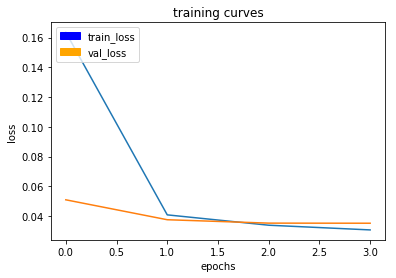

1032/1032 [==============================] - 217s - loss: 0.0307 - categorical_crossentropy: 0.0296 - val_loss: 0.0352 - val_categorical_crossentropy: 0.0340
Epoch 5/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0280 - categorical_crossentropy: 0.0270 - ETA: 87s - ETA: 77s - loss: 0.0278 - cat - ETA: 71s - loss: - ETA: 63s - loss: 0.0277 - categorical_crossentropy: 0.0 - ETA: 62s - loss: 0.0276 - categorical_cros - ETA: 59s - loss: 0.0276 - categori - ETA: 54s - loss: 0.0280 - categoric - ETA: 50s - loss: 0.0281 - categorical_crossentropy: 0.0 - ETA: 49s - loss: 0.0280 - categorical_crossen - ETA: 46s - loss: 0.0281 - categorical_cro - ETA: 43s - loss: 0.0280 - categorical_crossentropy: 0. - ETA: 42s - loss: 0.0280 - categorical_

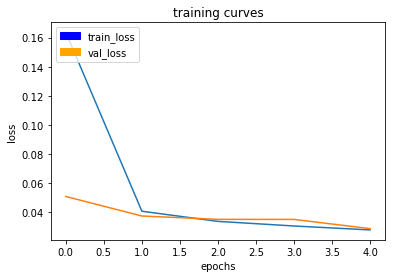

1032/1032 [==============================] - 220s - loss: 0.0280 - categorical_crossentropy: 0.0270 - val_loss: 0.0288 - val_categorical_crossentropy: 0.0277
Epoch 6/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0252 - categorical_crossentropy: 0.0244   ETA: 142s - loss: 0.0259 - categorical_crossentropy: 0.02 - ETA: 142s - loss: 0.0259 - categorical_crossent - ETA: 141s - loss: 0.0257 - categorical_crossentropy:  - ETA: 140s - loss: - ETA: 136s - loss: 0.0259 - categorical_crossentropy: 0.02 - ETA: 136s - loss: 0.0259 - categorical_cro - ETA:  - ETA: 72s - loss: 0.0251 - categorical_crossentropy: 0.0 - ETA: 71s - loss: 0.0251 - cat - ETA: 66s - loss: 0.0251 - categorical_crossentropy: - ETA: 64s - loss: 0.0251 - c - ETA: 58s - loss: 0.0258 - categorical_ - ETA: 54s - loss: 0.0258 - categor - ETA: 49s - loss: 0.0257 - ca - ETA: 43s - - ETA: 34s - loss: 0.0253 - categorical_crossentropy: 0.024 - ETA: 33s - loss: 0.0253 - categor - ETA: 28s - loss: 0.0252 - categorica

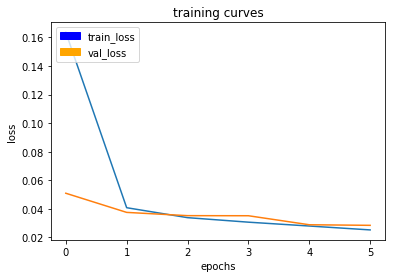

1032/1032 [==============================] - 218s - loss: 0.0252 - categorical_crossentropy: 0.0244 - val_loss: 0.0284 - val_categorical_crossentropy: 0.0275
Epoch 7/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0247 - categorical_crossentropy: 0.0239

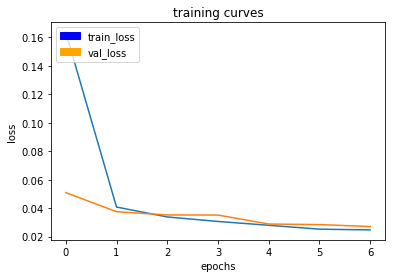

1032/1032 [==============================] - 218s - loss: 0.0247 - categorical_crossentropy: 0.0239 - val_loss: 0.0271 - val_categorical_crossentropy: 0.0262
Epoch 8/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0237 - categorical_crossentropy: 0.0229   ETA - ETA: 17  - ETA: 98s - loss: 0.0231 - categorical_crossentropy: 0.02 - ETA: 98s -  - ET - ETA: 7 - ETA: 67s - loss: 0.0237 - categorical_crossentropy: 0.0 - ETA: 66s - loss: 0.0237 - categorical_crossent - ETA: 64s - loss: 0.0238 - categorical_crossentr - ETA: 50s - loss: 0.0240 - categorical_crossentropy: 0.023 - ETA: 49s - loss: 0.0240 - categorical_crossentropy: 0.023 - ETA: 49s - loss: 0.0240 - categorical_crossentrop - ETA: 11s - loss: 0.0238 - categorical_crossentropy: 0 - ETA: 1 - ETA: 5s - loss: 0.0237 - categorical_ - ETA: 3s - loss: 0.0237 - catego - ETA: 0s - loss: 0.0237 - categorical_crossentropy: 0.02 - ETA: 0s - loss: 0.0237 - categorical_crossentropy: 0.02

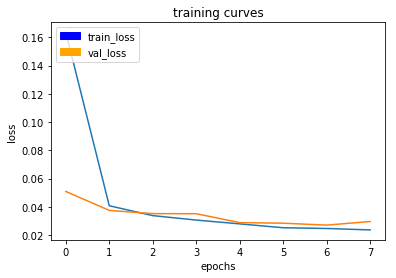

1032/1032 [==============================] - 218s - loss: 0.0237 - categorical_crossentropy: 0.0229 - val_loss: 0.0296 - val_categorical_crossentropy: 0.0286
Epoch 9/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0218 - categorical_crossentropy: 0.0211   ETA: 182s - loss: 0.0 - ETA: 178s - loss: 0.0206 - ca - ETA: 175s - loss: 0.0206 - categorical_crossentropy: 0.02 - ETA: 175s - - ETA: 158s - loss: 0.0206 - categorical_crossentropy: 0.01 - ETA:  - - ETA: 134s - loss: 0.021 - ETA: 118s - loss: 0.0221 - categorical_crossent - ETA - ETA: 112s - loss: 0.0223 - categorical_crossentropy: 0.02 - ETA: 111s - loss: 0.0223 - categorical_crossentropy: 0.02 - ETA: 111s - loss: 0.0223 - ca - ETA: 108s - loss: 0 - ETA: 10 - ETA: 99s - loss: 0.02 - ETA: 91s - loss: 0.0225 - categorical_crossentropy: 0 - ETA: 90s - loss: 0.0225 - categorical_c - ETA: 87s - loss: 0.0224 - categorical_cross - ETA: 84s - loss: 0.0224 - categorical_crossentropy - ETA: 82s - loss: 0.0225 - categorica - 

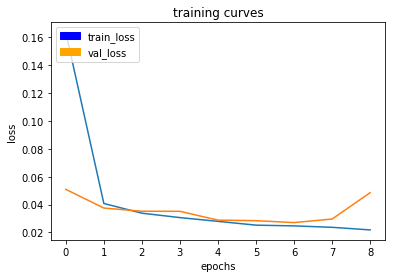

1032/1032 [==============================] - 218s - loss: 0.0218 - categorical_crossentropy: 0.0211 - val_loss: 0.0485 - val_categorical_crossentropy: 0.0474
Epoch 10/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0214 - categorical_crossentropy: 0.0207 8 ETA: 133s - loss: 0.0207 - categorical_cros - ETA: 132s - loss: 0.0207 - categorical_ - E - ETA: 99s - loss: 0.0204 - categorical_crossen - ETA: 97s - loss:  - ETA: 89s - loss: 0.0204 - categorical_crossent - ETA: 86s - loss: 0.0203 - categorical_cros - ETA: 83s - loss: 0.0203 - categorical_crossentropy: 0.019 - ETA: 83s - loss: 0.0203 - categorical_crossentropy: 0.0 - ETA: 82s - loss:  - ETA: 74s - loss: 0.0203 - categorical_crossentropy: 0. - ETA: 73s - loss: 0.0203 - categorical_crossentropy: 0. - ETA: 73s - loss: 0.0203 - categorical_crossentropy: 0.019 - ETA: 72s - loss: 0.0203 - categorical_crossentropy: 0.019 - ETA: 72s - loss: 0.0203 - categorical_crosse - ETA: 69s - loss: 0.0202 - cat - ETA: 64s - loss: 0.0

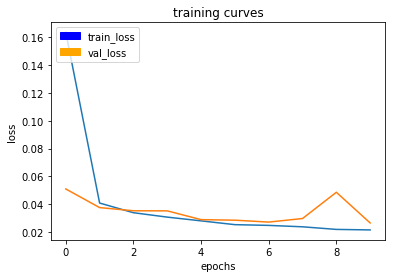

1032/1032 [==============================] - 217s - loss: 0.0214 - categorical_crossentropy: 0.0207 - val_loss: 0.0265 - val_categorical_crossentropy: 0.0253
Epoch 11/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0216 - categorical_crossentropy: 0.0208   ETA - ETA:  - ETA: 116s - loss: 0.0216 - cate - ETA: 113s - loss: 0.0217  - ETA: 95s - loss: 0.0 - ETA: 27s - loss: 0.0218 - categorical_crossentropy - - ETA: 0s - loss: 0.0216 - categorical_crossentropy: 0.0209

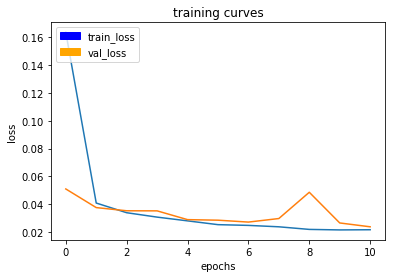

1032/1032 [==============================] - 218s - loss: 0.0216 - categorical_crossentropy: 0.0209 - val_loss: 0.0237 - val_categorical_crossentropy: 0.0228
Epoch 12/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0201 - categorical_crossentropy: 0.0194   ETA: 198s - loss: 0.0171 - categorical_crossentro - ETA: 19 - ETA: 121s - loss: 0.0199 - ca - E - ETA: 112s - loss: 0.0203 - categorical_ - ETA: 104 - ETA: 99s - loss: 0.0200 - categorical - ETA: 95s - loss: 0.0202 - categorical_crossentropy: 0.0 - ETA: 94s - loss: 0.0204 - categorical_crossentropy: 0.01 - ETA: 94s - loss: 0.0203 - categorica - ETA: 90s - loss: 0.0202 - catego - ETA: 85s - loss: 0.0200 - categorical_crossentr - ETA: 82s - loss: 0.0200 - categoric - ETA: 78s - loss: 0.0199 - categorical_crossentropy: 0.0 - ETA: 77s - loss: 0.0198 - categorical_crossentropy: 0.019 - ETA: 77s - loss: 0.0198 - categorical_crossentropy: 0 - ETA: 76s - loss: 0.0199 - categorical_cros - ETA: 73s - loss: 0.0199 - categorica

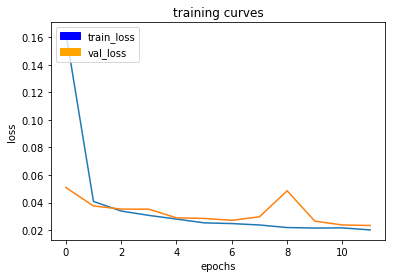

1032/1032 [==============================] - 217s - loss: 0.0201 - categorical_crossentropy: 0.0194 - val_loss: 0.0233 - val_categorical_crossentropy: 0.0224
Epoch 13/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0201 - categorical_crossentropy: 0.0194   ETA: 205s - loss: 0.013 - ETA: 198s - - ETA: 182s - loss: 0.020 - E - ETA: 167s - loss: 0.0205 - categorical_crossentropy: 0. - ETA: 105s - loss: - ETA: 101s - loss: 0.0215 - cate - ETA: 97s - loss: 0.0214 - categorical_crossentrop - ETA: 96s  - ETA: 86s - loss: 0.0209 - categ - ETA: 81s - loss: 0.02 - ET - ETA: 38s - loss: 0.0204 - categorical_crossentr - ETA: 36s

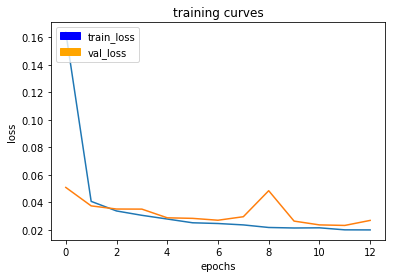

1032/1032 [==============================] - 217s - loss: 0.0200 - categorical_crossentropy: 0.0194 - val_loss: 0.0270 - val_categorical_crossentropy: 0.0259
Epoch 14/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0195 - categorical_crossentropy: 0.0188  - ETA: 83s - loss: 0.0197 - categori - ETA: 78s - loss: 0.0196 - categorical_cros - ETA: 75s - loss: 0.019 - ETA: 56s - loss: 0.0195 - categorical_crossentropy: 0.018 - ETA: 56s - loss: 0.0195 - categorical - ETA: 51s - loss: 0.0195 - ETA: 45s - loss: 0.0194 - categorical_crossentropy: 0.018 - ETA: 44s - loss: 0.0193 - categorical_crossentropy - ETA: 31s - loss: 0.0194 - categorical_crossentropy: 0.018 - ETA: 31s - loss: 0. - ETA: 23s - loss: 0.0194 - categorical_crossentropy: 0.01 - ETA: 22s - loss: 0.0194  - ETA: 16s - loss: 0.0194 - categorical_cr - ETA: 1

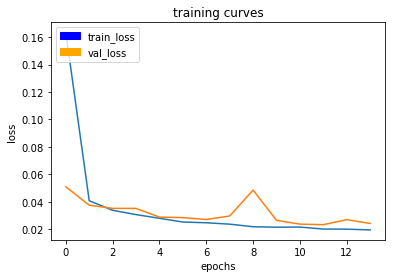

1032/1032 [==============================] - 217s - loss: 0.0195 - categorical_crossentropy: 0.0188 - val_loss: 0.0242 - val_categorical_crossentropy: 0.0232
Epoch 15/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0192 - categorical_crossentropy: 0.0185   ETA: 103s - loss: 0.0174 - categorica - ETA: 101s - loss:  - ETA: 95s - loss: 0.0175 - categorical_crossentropy: 0.01 - ETA: - ETA: 48s - loss: 0.0186 - categorical_crossentrop - ETA: 46s - loss: 0

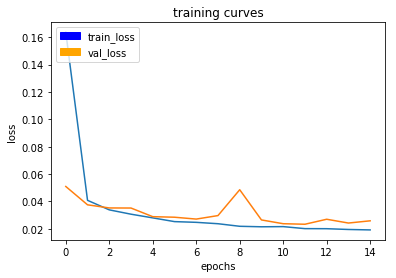

1032/1032 [==============================] - 217s - loss: 0.0192 - categorical_crossentropy: 0.0185 - val_loss: 0.0258 - val_categorical_crossentropy: 0.0249
Epoch 16/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0186 - categorical_crossentropy: 0.0180 - ETA: 84s - loss: 0.0192 - categorical_crossentropy: 0. - ETA: 83s - loss: 0.0192 - catego - ETA: 78s - loss: 0.0190 - categorical_crossentrop - ETA: 76s - loss: 0.019 - ETA: 69s - loss: 0.0190 - categorical_c - ETA: 66s - loss: 0.0190 - categorical_crossentropy: 0 - ETA: 65s - loss: 0.0189 - categorical_crossent - ETA: 62s - loss: 0.0 - ETA: 55s - loss: 0.0187 - categorical_crossent - ETA: 52s - loss: 0 - ETA: 44s - loss: 0.0187 - categorical_cr - ETA: 41s - loss: 0.0187 - categorical_crossentropy: 0.018 - ET - ETA: 30s - loss: 0.0186 - categorical_crossentrop - ETA: 16s - loss: 0.0186 - categorica - ETA: 11s -

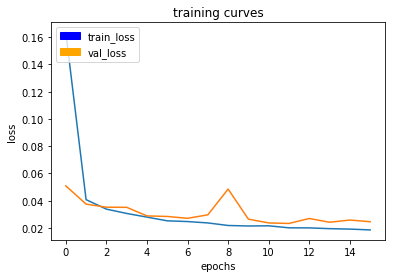

1032/1032 [==============================] - 217s - loss: 0.0186 - categorical_crossentropy: 0.0180 - val_loss: 0.0246 - val_categorical_crossentropy: 0.0236
Epoch 17/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0178 - categorical_crossentropy: 0.0172 - ETA: 57s - loss: 0.0172 - categorical_crossentr - ETA: 55s - loss: 0.0171 - categorica - ETA: 50 - E - ETA: 29s - loss: 0.0174 - categorical_crossentropy: 0.01 - ETA: 29s - loss: 0.0174 - categorical_crossentropy: 0 - ETA: 28s - loss: 0.0 - ETA: 20s - loss: 0.0176 - categorica - ETA: 16s - loss: 0.0177 - categorical_crossentropy:  - ETA: 0s - loss: 0.0178 - categorical_crossentropy: 0.01

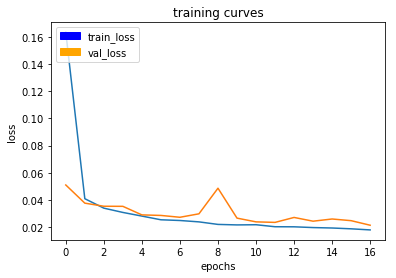

1032/1032 [==============================] - 217s - loss: 0.0178 - categorical_crossentropy: 0.0172 - val_loss: 0.0212 - val_categorical_crossentropy: 0.0204
Epoch 18/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0176 - categorical_crossentropy: 0.0170   ETA: 142s - loss: 0.0178 - categorical_ - ETA: 141s - ETA: 117s - loss: 0.0175 - categorical_crossentropy: 0.01 - ETA: 117s - loss: 0.0175  - ETA: 114s - loss: 0.0175 - categorical_crossentropy: 0.01 - ETA: 113s - loss: 0.0175 - categorical_crossentropy: 0. - ETA: 113s - loss: 0 - ETA: 94s - loss: 0.0 - ETA: 87s - loss: 0.0181 - categorical_ - ETA: 83s - loss: 0.0181 - categorical_crosse - ETA: 80s - loss: 0.0181 -  - ETA: 74s - loss: 0.0179 - categorical_crossentro -  - ETA: 60s - loss: 0.0180 - categorical_cros - ETA: 57s - loss: 0 - ETA: 49s - loss: 0 - ETA: 41s - loss: 0.0178 - categorical_crossentropy:  - ETA: 40s - - ETA: 30s - loss: 0.0180 - ca - ETA: 24s - loss: 0.0179 - categorical_crossentro - ETA: 22s - l

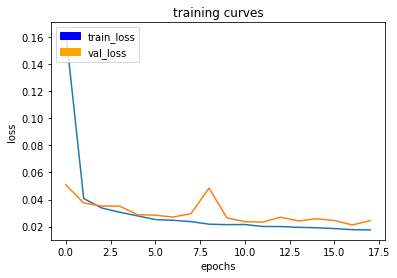

1032/1032 [==============================] - 217s - loss: 0.0176 - categorical_crossentropy: 0.0170 - val_loss: 0.0245 - val_categorical_crossentropy: 0.0235
Epoch 19/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0170 - categorical_crossentropy: 0.0165 - ETA: 71s - loss: 0.0168 - categori - ETA: 66s - loss: 0.0167 - categorical_crossentropy: 0.016 - ETA: 66s - loss: 0.0167 - categoric - ETA: 62s - los - ETA: 7s - loss: 0 - ETA: 3s - loss: 0.0167 

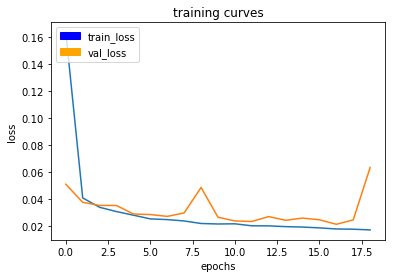

1032/1032 [==============================] - 217s - loss: 0.0170 - categorical_crossentropy: 0.0165 - val_loss: 0.0633 - val_categorical_crossentropy: 0.0621
Epoch 20/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0176 - categorical_crossentropy: 0.0171   ETA: 201s - loss: 0.0221 - categorical_cr - ETA: 198s - loss: 0.0202  - ETA: 195s - los - ETA: 191s - l - ETA: 168s - loss: 0.0173  - ETA: 165s - loss: 0 - ETA: 100s - loss: 0.0182 - categorical_crosse - ETA: 98s - loss: 0.0182 - categorical_crossent - ETA: 95s - loss: 0.0183 - categorical - ETA: 91s - loss: 0.0183 - categorical_crossentropy: 0.017 - ETA: 91s - ETA: 6 - ETA: 47s - loss: 0.0179 - ca - - ETA: 1s - loss: 0.0177 - categorical_cros

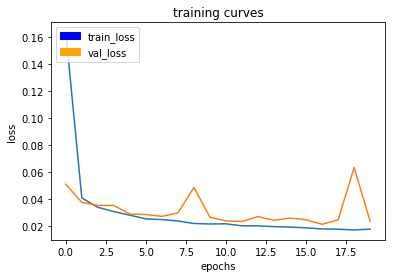

1032/1032 [==============================] - 217s - loss: 0.0176 - categorical_crossentropy: 0.0171 - val_loss: 0.0234 - val_categorical_crossentropy: 0.0225
Epoch 21/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0166 - categorical_crossentropy: 0.0161   ETA:  - ETA: 124s - loss: 0.0156 - catego - ETA: 103s - loss: 0.0154 - categorical_cr - ETA: 101s - loss: 0.0154 - categori - ETA: 99s - loss: 0.0161  - ETA: 80s - loss: 0.0163 - categorical_crossentr - ETA: 78s - loss: 0.0163 - categori - ETA: 73s - loss: 0.0168 - categorical_cross - ETA: 70s - loss: 0.0168 - categorical_crossentropy: 0.016 - ETA: 70s - loss: 0.0168 - categorical_crossentropy: 0.01 - ETA: 69s - loss: 0.0168 - categorical_crossentr - ETA: 67s - loss: 0.0169 - categor  - ETA: 50s - loss: 0.0170 - categorical_cros - ETA: 47s - loss: 0.0170 - catego - ETA: 42s - loss: 0.0169 - categorical_crossentropy: 0 - ETA: 41s - loss: 0.0169 - categorical_crossentropy: 0.016 - ETA: 41s - loss: 0.0169 - categorical

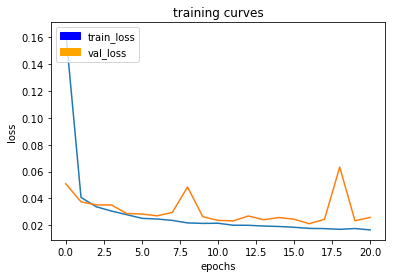

1032/1032 [==============================] - 217s - loss: 0.0166 - categorical_crossentropy: 0.0161 - val_loss: 0.0259 - val_categorical_crossentropy: 0.0249
Epoch 22/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0162 - categorical_crossentropy: 0.0157   ETA: 176s - loss: 0.0149 - ca - ETA: 17 - E - ETA: 101s - loss: 0.0165 - categorical_ - ETA: 99s - loss: 0.016 - ETA: 92s - loss: 0.0164 - cat - ETA: 86s - loss: 0.0164 - categorical_crossentropy - ETA: 85s - loss: 0.0163 - categorical_crossentropy - ETA: 8 - ETA: 73s - loss: 0.0163 - categori - ETA: 68s - loss: 0.01 - ETA - ETA: 50s - loss: 0.0168 - ca - ETA: 32s - loss: 0.0166 - categorical_crossent - ETA: 29s - loss - ETA: 3s - loss: 0.0163 

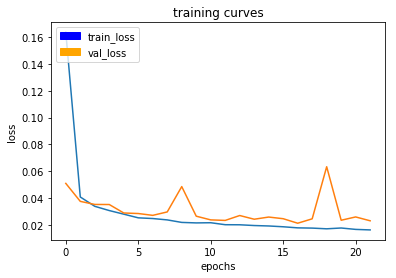

1032/1032 [==============================] - 217s - loss: 0.0162 - categorical_crossentropy: 0.0157 - val_loss: 0.0230 - val_categorical_crossentropy: 0.0221
Epoch 23/30
1031/1032 [============================>.] - ETA: 0s - loss: 0.0166 - categorical_crossentropy: 0.0161   ETA: 162s - loss: 0.0161 - categorical_crossentropy: 0.01 - ETA: 162s - loss: - ETA: 157s - loss: 0.0161 - categorica - - ETA - ETA: 78s - loss: 0.0159 - categorical_crossen - ETA: 76s - loss: 0.0159  - ETA: 69s - los - ETA: 60s - loss: 0.0160 - categor - ETA: 55s - los - ETA: 46s - loss: 0.0159 - categorical_crossentropy: 0.01 - ETA: 46s - loss: 0.0159 - categori - ETA: 41s - loss: 0.0166 - cat - ETA: 36s - loss: 0.0167 - categorical_crossentropy: 0 - ETA: 35s - loss: 0.0167 - categorical_crossentropy: - ETA: 33s - loss: 0.0167 - categorical_crossentropy: 0.016 - ETA: 33s - loss: 0.0167 - categorical_crossentropy: 0.016 - ETA: 33s - loss: 0.0167 - ca - ETA: 27s - loss: 0.0167 - categorical_crossentropy: 0. 

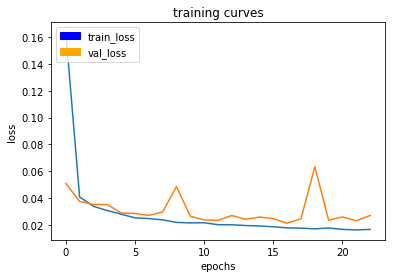

1032/1032 [==============================] - 217s - loss: 0.0166 - categorical_crossentropy: 0.0161 - val_loss: 0.0270 - val_categorical_crossentropy: 0.0259
Epoch 00022: early stopping


In [149]:
# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train_combined'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
lr_plateau_cb = keras.callbacks.ReduceLROnPlateau(monitor="categorical_crossentropy", patience=3, min_lr=0.0001)
file_logger_cb = keras.callbacks.CSVLogger("../logs/run1.csv", append=False)
checkpoints_cb = keras.callbacks.ModelCheckpoint("../data/weights/checkpoints/weights.{epoch:02d}-{val_loss:.4f}.hdf5", monitor="categorical_crossentropy", save_best_only=True, period=5)
early_stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min')
callbacks = [logger_cb, lr_plateau_cb, file_logger_cb, checkpoints_cb, early_stop_cb]

history = model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)
                             #initial_epoch=24)

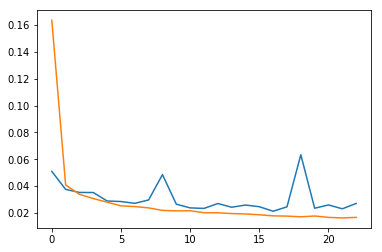

In [150]:
plt.plot(history.epoch, history.history['val_loss'])
plt.plot(history.epoch, history.history['loss'])
plt.show()

In [161]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [151]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

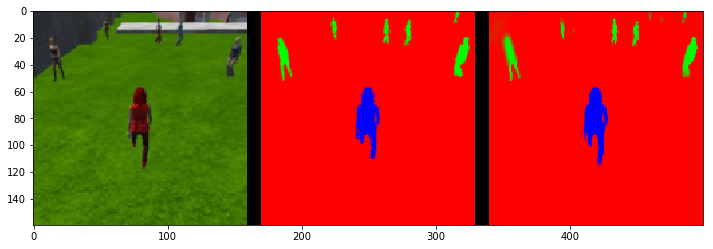

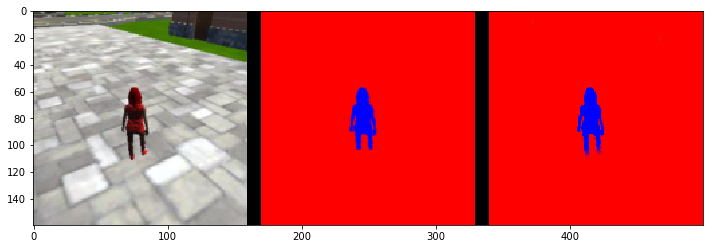

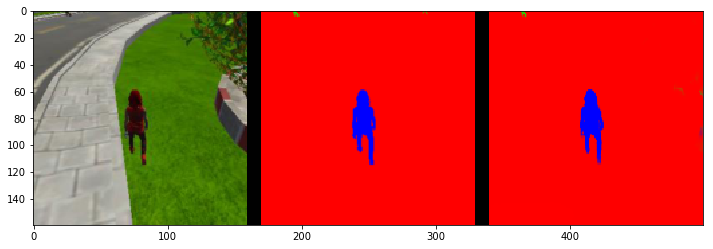

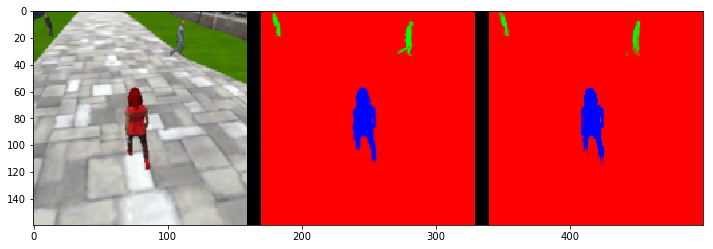

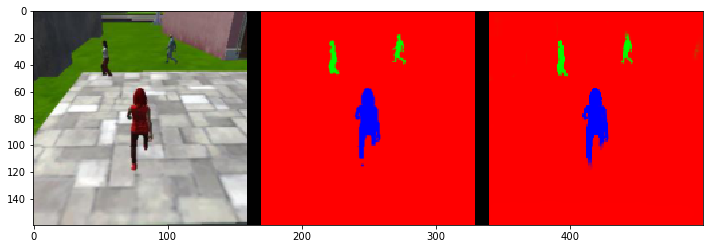

In [152]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(5):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

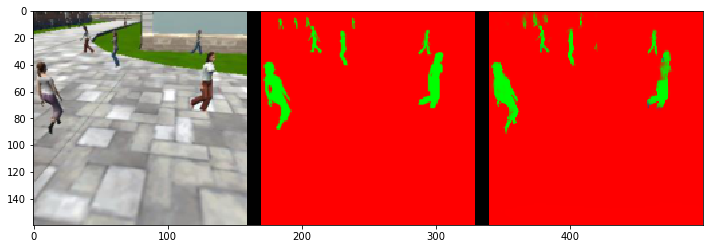

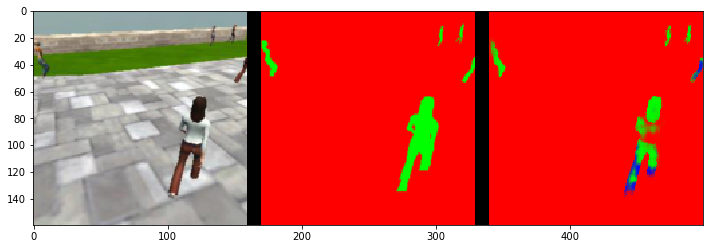

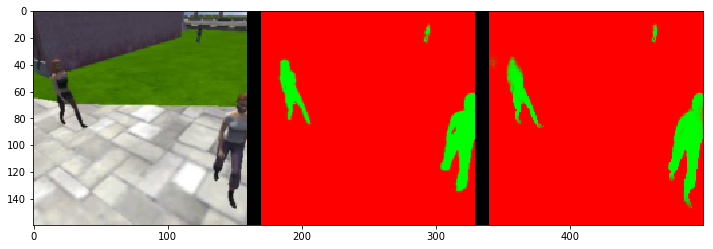

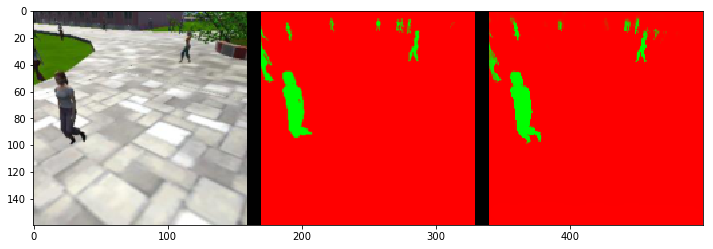

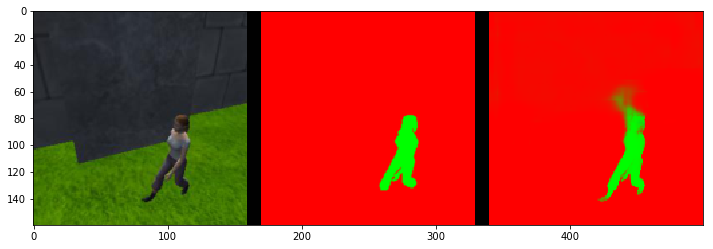

In [153]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(5):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

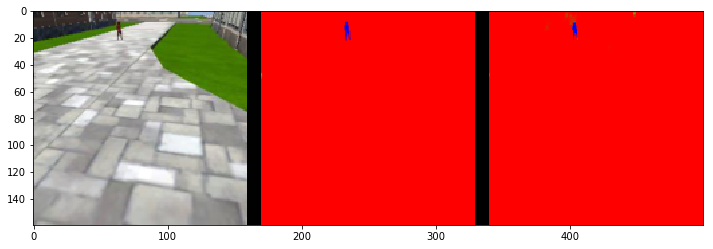

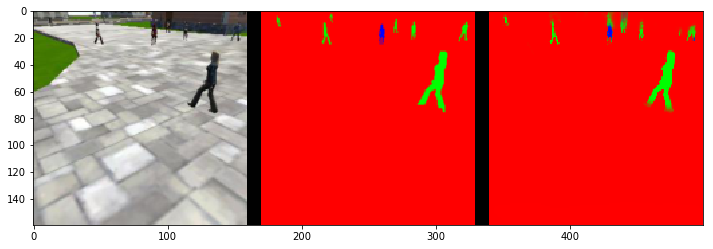

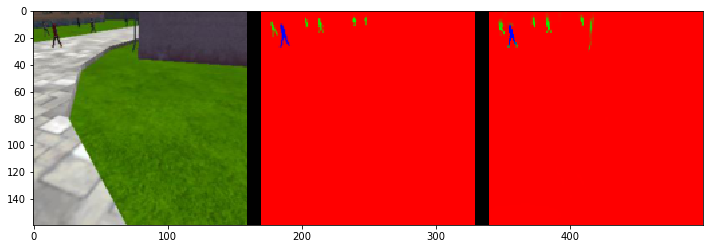

In [154]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [155]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9961241382192249
average intersection over union for other people is 0.42359744017596923
average intersection over union for the hero is 0.9257796831545205
number true positives: 539, number false positives: 0, number false negatives: 0


In [156]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9899191742405778
average intersection over union for other people is 0.7933521736563829
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 60, number false negatives: 0


In [157]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9971384299013222
average intersection over union for other people is 0.5117499386314773
average intersection over union for the hero is 0.31008687499445425
number true positives: 155, number false positives: 2, number false negatives: 146


In [158]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7694013303769401


In [159]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.617933279074


In [160]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.475438687004
